## 三维可视化

这里我们先展示数据的三维可视化结果。

In [ ]:
!pip install vtk itk k3d

In [1]:
import vtk, vtkmodules
import itk

使用 `itk` 读取数据，并转为 `vtk` 格式

In [2]:
file = './sampledata.nii.gz'
itk_img = itk.imread(file)
vtk_img = itk.vtk_image_from_image(itk_img)
type(vtk_img)

vtkmodules.vtkCommonDataModel.vtkImageData

### 体三维重建

调用 `vtk` 本身模块进行三维重建，产生一个 volume

volume 是一个“体”，与常规三维重建得到的 mesh （表面）不同，volume 包含一个三维区域内部的信息，mesh 只有一个表面（二维流形）的信息，内部信息未知。

In [3]:
renderer = vtk.vtkRenderer()

# 创建一个vtkRenderWindow对象，用于显示vtkRenderer对象中的内容
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

# 创建一个vtkRenderWindowInteractor对象，用于处理交互事件
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# 3D高斯平滑 2023/03/24新增
smoother = vtkmodules.vtkImagingGeneral.vtkImageGaussianSmooth()
smoother.SetDimensionality(3)
smoother.SetStandardDeviation(2, 2, 2)
smoother.SetInputData(vtk_img)
smoother.Update()

# 应用体绘制算法，生成三维模型
volume_mapper = vtk.vtkGPUVolumeRayCastMapper()
# Jpg_Reader.GetOutput()的输出为vtkImageData
volume_mapper.SetInputData(smoother.GetOutput())

# 定义颜色映射
color_transfer_function = vtk.vtkColorTransferFunction()
# 越接近黑色0越暗, 越接近白色255越亮
color_transfer_function.AddRGBPoint(0, 0.0, 0.0, 0.0)
color_transfer_function.AddRGBPoint(255, 1.0, 1.0, 1.0)

# 设置不透明度函数
opacity_transfer_function = vtk.vtkPiecewiseFunction()
# 把像素值低于15的设置为透明, 去除黑色0, 白色255则不透明
threshold = 15
opacity_transfer_function.AddPoint(threshold , 0.0)
opacity_transfer_function.AddPoint(255, 1.0)

# 设置vtkVolume参数
volume_property = vtk.vtkVolumeProperty()
volume_property.SetColor(color_transfer_function)
volume_property.SetScalarOpacity(opacity_transfer_function)
# 是否开启阴影
# volume_property.ShadeOn()
# 设置线性插值方式
volume_property.SetInterpolationTypeToLinear()

# 将vtkVolumeMapper、vtkVolumeProperty和vtkVolume组合在一起
volume = vtk.vtkVolume()
volume.SetMapper(volume_mapper)
volume.SetProperty(volume_property)

renderer.AddVolume(volume)


定义一个显示函数，将 `vtk` 的 `vtkRenderer` 格式转为图片显示

In [4]:
from IPython.display import Image

def vtk_write(renderer, filename, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(filename)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()



将三维重建图片写入到 `png`，并展示三维重建图片

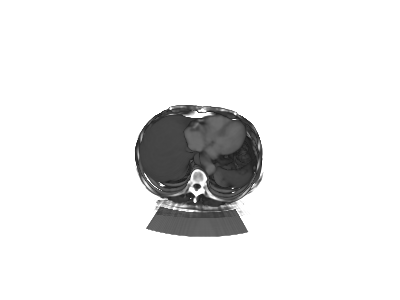

In [5]:
# 设置背景为白色
renderer.SetBackground(1.0, 1.0, 1.0)

vtk_write(renderer, filename="output.png")

from PIL import Image

display(Image.open("output.png"))

可以指定相机视角，查看其他方向

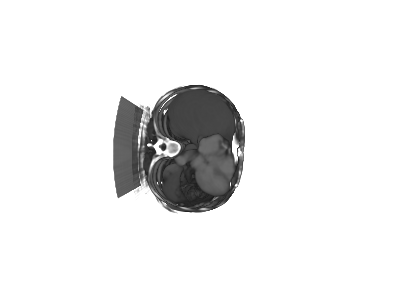

In [6]:
camera = renderer.GetActiveCamera()
#设置视角
camera.SetViewUp(-1, 0, 0)
vtk_write(renderer, filename="output.png")

from PIL import Image

display(Image.open("output.png"))

### 三维交互

利用 `k3d` 包，可以在 Jupyter Notebook 中实现三维可视化交互。

由于 `k3d` 只能接受 `vtkPolyData` 作为输入，这里选择 `FlyingEdges` 作为三维重建方法

In [7]:
iso_value = 0.5
flying_edges = vtk.vtkFlyingEdges3D()
flying_edges.SetInputData(vtk_img)
flying_edges.SetValue(0, iso_value)
flying_edges.Update()

mesh = flying_edges.GetOutput()

In [9]:
import k3d

model_matrix = (
     1.0,  0.0, 0.0, 0.0,
     0.0,  1.0, 0.0, 0.0,
     0.0,  0.0, 1.0, 0.0,
     0.0,  0.0, 0.0, 1.0
)

plot = k3d.plot()
cow3d = k3d.vtk_poly_data(mesh, color=0xff0000, model_matrix=model_matrix)
plot += cow3d
plot.display()

Output()